## Real

In [1]:
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen import EmbeddingGenerator
from nli_300 import NLI_Heads_300k
from validation2 import Validation
from train2 import Train
from other_utils import print_progress
import torch
import json
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 8
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(eval_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, evidence=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)
evidence_dataset = WikiDataset(reduced=False, in_mem=True, evidence=True)
evidence_dataloader = DataLoader(evidence_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = NLI_Heads_300k(device=device)

loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.25)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': emb_gen.parameters(), 'lr': 1e-6},
    {'params': nli.parameters(), 'lr': 5e-4}
], fused=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=0, verbose=True)


tracking_eval = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

In [7]:
#load the best models, optimizers, schedulers, and tracking dictionaries

emb_gen.load_state_dict(torch.load('models/emb_gen_v5.pth'))
nli.load_state_dict(torch.load('models/nli_v5.pth'))
optimizer.load_state_dict(torch.load('models/optimizer_v5.pth'))
scheduler.load_state_dict(torch.load('models/scheduler_v5.pth'))
with open('metrics/tracking_eval_v5.json', 'r') as f:
    tracking_eval = json.load(f)
with open('metrics/tracking_train_v5.json', 'r') as f:
    tracking_train = json.load(f)

avg_cond_f1 = []
for i in range(0, len(tracking_eval['conditional_f1']), 3):
    avg_cond_f1.append(np.mean(tracking_eval['conditional_f1'][i:i+3]))

strike_one = False if avg_cond_f1[-1] == max(avg_cond_f1) else True

/tmp/ipykernel_8230/2871080110.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_gen.load_state_dict(torch.load('models/emb_gen_v5.pth'))
/tmp/ipykernel_8230/287108011

In [3]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
evdb = VectorDatabase(wiki_loader=evidence_dataloader, emb_gen=emb_gen, host='docker', version='ve')

Creating collection
Block 1/542 done
Block 2/542 done
Block 3/542 done
Block 4/542 done
Block 5/542 done
Block 6/542 done
Block 7/542 done
Block 8/542 done
Block 9/542 done
Block 10/542 done
Block 11/542 done
Block 12/542 done
Block 13/542 done
Block 14/542 done
Block 15/542 done
Block 16/542 done
Block 17/542 done
Block 18/542 done
Block 19/542 done
Block 20/542 done
Block 21/542 done
Block 22/542 done
Block 23/542 done
Block 24/542 done
Block 25/542 done
Block 26/542 done
Block 27/542 done
Block 28/542 done
Block 29/542 done
Block 30/542 done
Block 31/542 done
Block 32/542 done
Block 33/542 done
Block 34/542 done
Block 35/542 done
Block 36/542 done
Block 37/542 done
Block 38/542 done
Block 39/542 done
Block 40/542 done
Block 41/542 done
Block 42/542 done
Block 43/542 done
Block 44/542 done
Block 45/542 done
Block 46/542 done
Block 47/542 done
Block 48/542 done
Block 49/542 done
Block 50/542 done
Block 51/542 done
Block 52/542 done
Block 53/542 done
Block 54/542 done
Block 55/542 done

Epoch: 0
Batch: 1/1


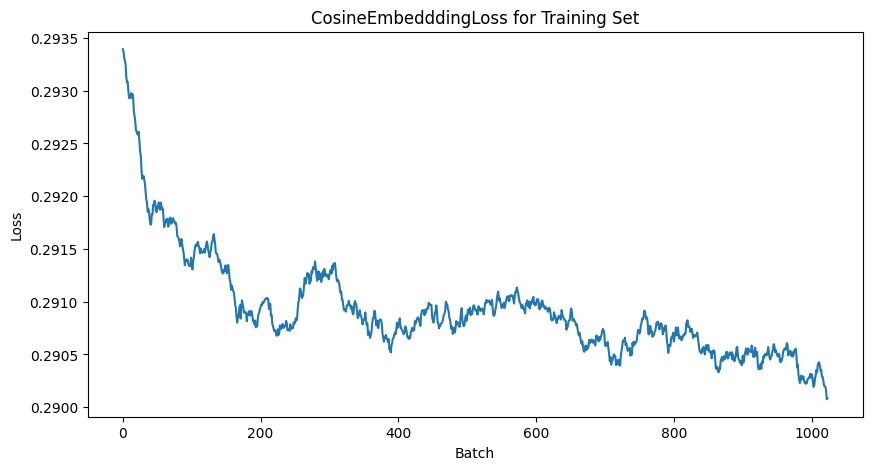

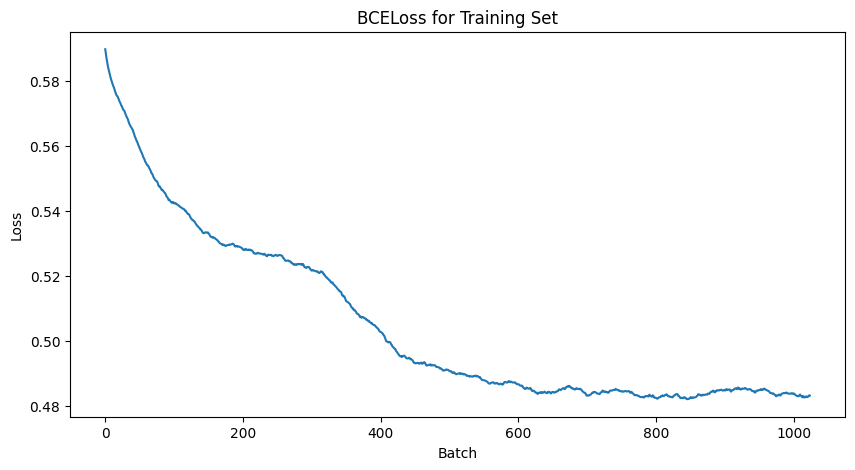

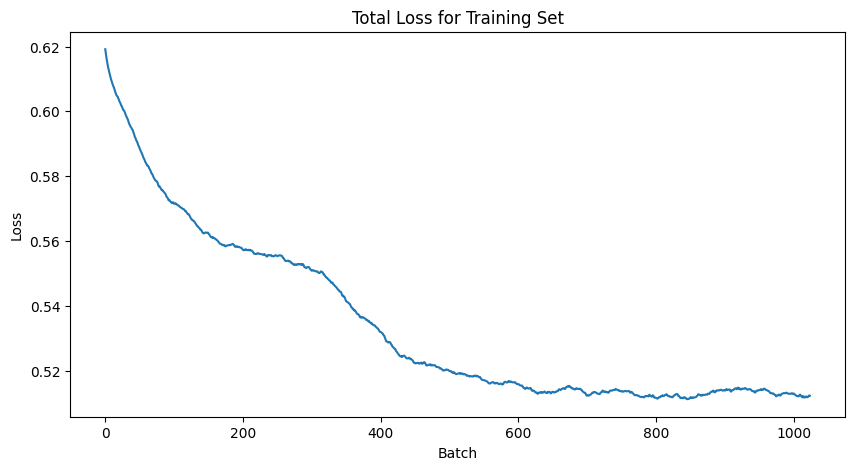

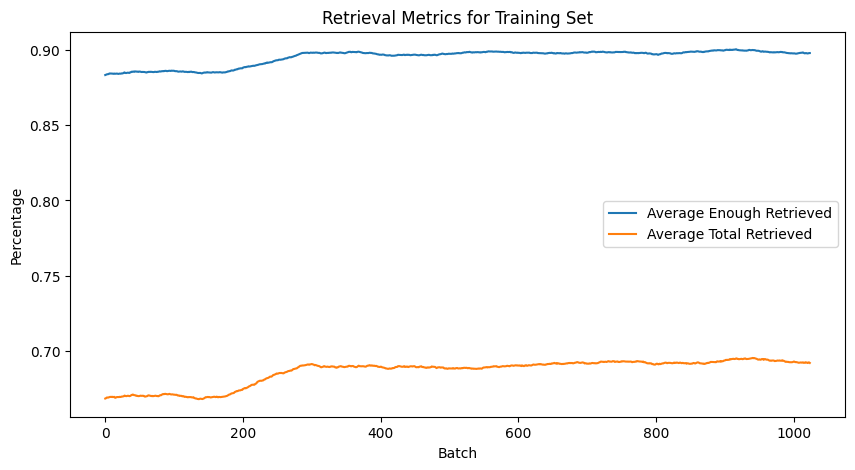

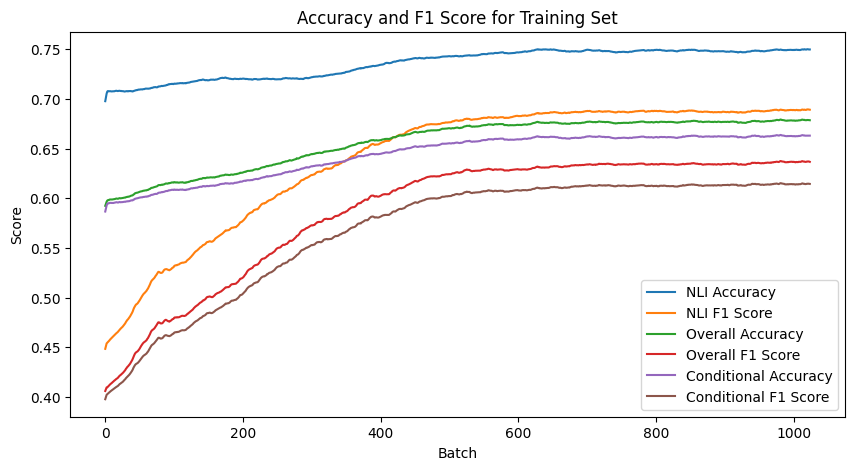

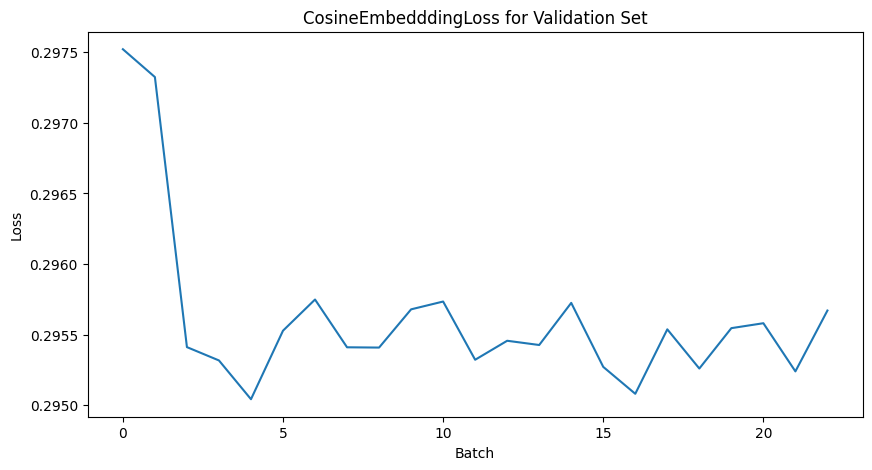

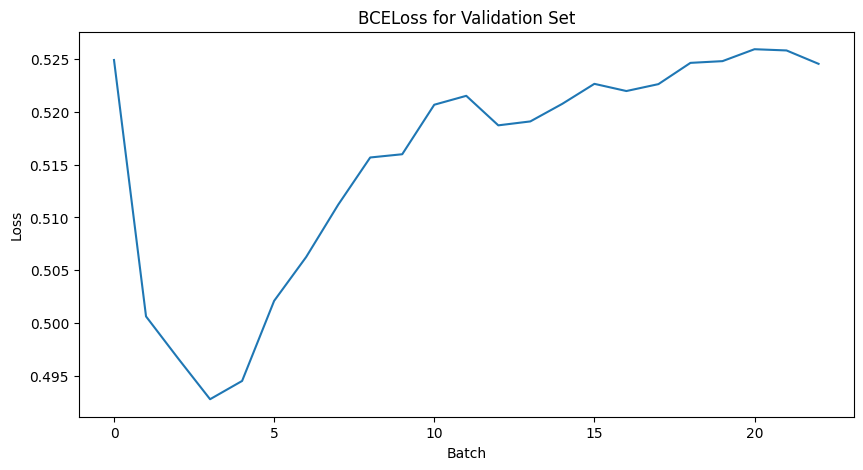

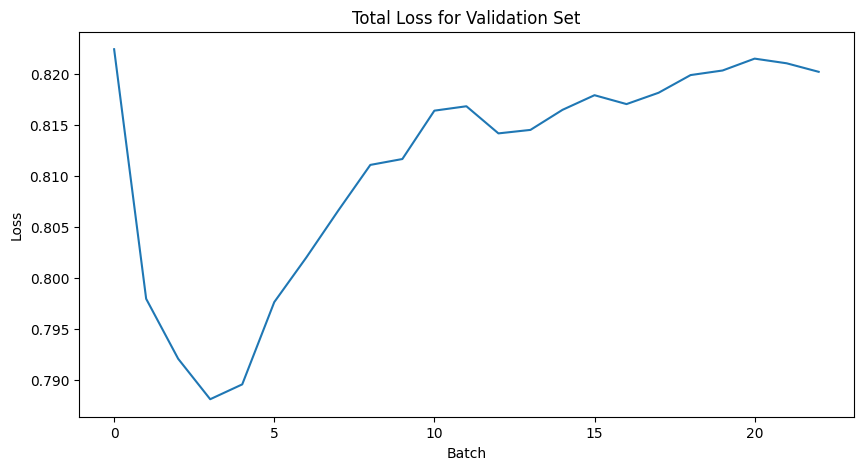

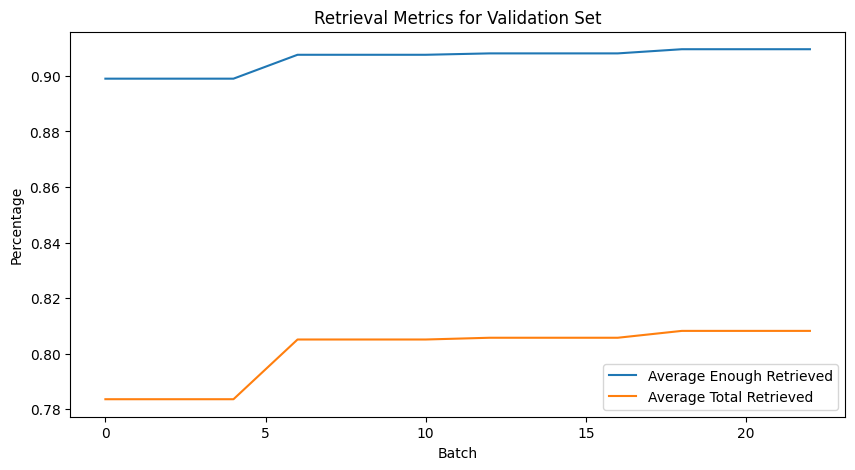

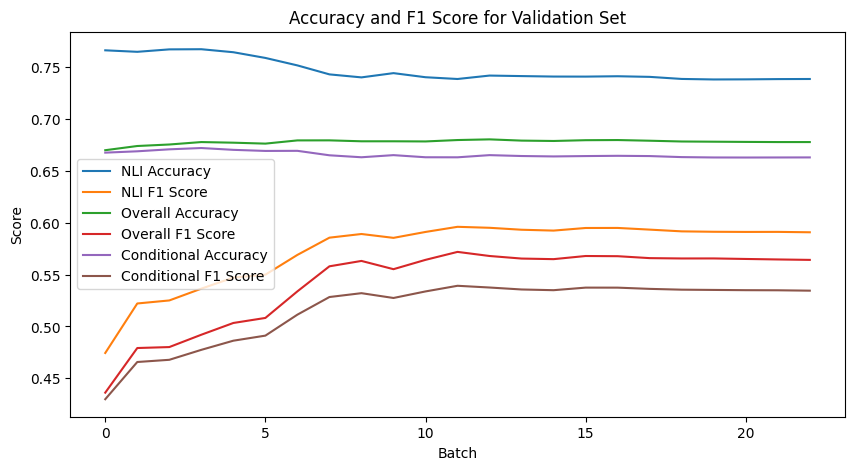

In [5]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
evdb = VectorDatabase(wiki_loader=evidence_dataloader, emb_gen=emb_gen, host='docker', version='ve')

# strike_one = False
# avg_cond_f1 = []
for epoch in range(len(avg_cond_f1), N_EPOCHS):
    if epoch % 2 == 0:
        train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, vdb=vdb, evdb=evdb, emb_gen=emb_gen)
        val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
        
    train.train_epoch(epoch=epoch, emb_gen=emb_gen, nli=nli, val=val, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=256, ma_ratio=0.1)
    val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)

    scheduler.step(np.mean(tracking_eval['average_total_loss'][-3:]))

    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    
    # save the metrics
    with open('metrics/tracking_train_v5.json', 'w') as f:
        json.dump(tracking_train, f)
    with open('metrics/tracking_eval_v5.json', 'w') as f:
        json.dump(tracking_eval, f)
        
    # save the model if it is the best one, return True if it is not to stop the training
    avg_cond_f1.append(np.mean(tracking_eval['conditional_f1'][-3:]))
    if avg_cond_f1[-1] == max(avg_cond_f1):
        torch.save(emb_gen.state_dict(), 'models/emb_gen_v5.pth')
        torch.save(nli.state_dict(), 'models/nli_v5.pth')
        torch.save(optimizer.state_dict(), 'models/optimizer_v5.pth')
        torch.save(scheduler.state_dict(), 'models/scheduler_v5.pth')
        strike_one = False
    else:
        torch.save(emb_gen.state_dict(), 'models/emb_gen_v5_latest.pth')
        torch.save(nli.state_dict(), 'models/nli_v5_latest.pth')
        torch.save(optimizer.state_dict(), 'models/optimizer_v5_latest.pth')
        torch.save(scheduler.state_dict(), 'models/scheduler_v5_latest.pth')
        if strike_one:
            break
        strike_one = True

    # if epoch % 2 == 1:
    #     vdb.refresh(emb_gen, 'vx', delete=True)
    #     evdb.refresh(emb_gen, 'vex', delete=True)
    #     time.sleep(600)

In [6]:
avg_cond_f1

[0.4437838953559357,
 0.47875047704296864,
 0.5191331956760183,
 0.5322444299929434,
 0.5358537982988726,
 0.5373170443113965,
 0.5351646507005374,
 0.5346856809623924]

# Test

In [2]:
## load the models
emb_gen.load_state_dict(torch.load('models/emb_gen_v5.pth'))
nli.load_state_dict(torch.load('models/nli_v5.pth'))

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='vx')

/tmp/ipykernel_8230/2501309023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_gen.load_state_dict(torch.load('models/emb_gen_v5.pth'))


Creating collection


/tmp/ipykernel_8230/2501309023.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nli.load_state_dict(torch.load('models/nli_v5.pth'))


Block 1/542 done
Block 2/542 done
Block 3/542 done
Block 4/542 done
Block 5/542 done
Block 6/542 done
Block 7/542 done
Block 8/542 done
Block 9/542 done
Block 10/542 done
Block 11/542 done
Block 12/542 done
Block 13/542 done
Block 14/542 done
Block 15/542 done
Block 16/542 done
Block 17/542 done
Block 18/542 done
Block 19/542 done
Block 20/542 done
Block 21/542 done
Block 22/542 done
Block 23/542 done
Block 24/542 done
Block 25/542 done
Block 26/542 done
Block 27/542 done
Block 28/542 done
Block 29/542 done
Block 30/542 done
Block 31/542 done
Block 32/542 done
Block 33/542 done
Block 34/542 done
Block 35/542 done
Block 36/542 done
Block 37/542 done
Block 38/542 done
Block 39/542 done
Block 40/542 done
Block 41/542 done
Block 42/542 done
Block 43/542 done
Block 44/542 done
Block 45/542 done
Block 46/542 done
Block 47/542 done
Block 48/542 done
Block 49/542 done
Block 50/542 done
Block 51/542 done
Block 52/542 done
Block 53/542 done
Block 54/542 done
Block 55/542 done
Block 56/542 done
B

In [3]:
# evaluate on the test set
tracking_test = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

test_fever_dataset = FeverDataset(type='test')
test_fever_loader = DataLoader(test_fever_dataset, len(test_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
test = Validation(device=device, eval_loader=test_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
test.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_test)
print(tracking_test)

{'nli_accuracy': [0.7320732073207321], 'nli_f1': [0.59161625834753], 'overall_accuracy': [0.6772677267726772], 'overall_f1': [0.5706903716470203], 'conditional_accuracy': [0.6605660566056606], 'conditional_f1': [0.5380751022897106], 'average_enough_retrieved': [0.9117911791179117], 'average_total_retrieved': [0.8010156571212672], 'average_loss1': [0.2934463469276003], 'average_loss2': [0.5347687926641695], 'average_total_loss': [0.8282151385477394]}


In [4]:
with open('metrics/tracking_test_v5.json', 'w') as f:
     json.dump(tracking_test, f)

In [8]:
tracking_eval

{'nli_accuracy': [0.7676767676767676,
  0.7646764676467647,
  0.7647764776477648,
  0.7693769376937694,
  0.7650765076507651,
  0.7635763576357636,
  0.7540754075407541,
  0.7491749174917491,
  0.7367736773677368,
  0.7433743374337434,
  0.744974497449745,
  0.7354735473547355,
  0.7415741574157416,
  0.742074207420742,
  0.7405740574057406,
  0.7411741174117412,
  0.7404740474047404,
  0.7418741874187419,
  0.7392739273927392,
  0.7378737873787379,
  0.7382738273827383,
  0.738073807380738,
  0.7387738773877388,
  0.7382738273827383],
 'nli_f1': [0.4342857142857142,
  0.5144565568200323,
  0.5297339451669332,
  0.5203106950040917,
  0.5524485484915997,
  0.5417300049833121,
  0.5579720310156688,
  0.5799104898733561,
  0.5911859576600276,
  0.5869737686981477,
  0.5837441346131743,
  0.5983760286113642,
  0.5936421408318009,
  0.5964912824246555,
  0.5898853461530434,
  0.5948546403489985,
  0.594900718502547,
  0.5949586503394455,
  0.5916496742575258,
  0.5916056357825394,
  0.59085

In [5]:
tracking_test

{'nli_accuracy': [0.7320732073207321],
 'nli_f1': [0.59161625834753],
 'overall_accuracy': [0.6772677267726772],
 'overall_f1': [0.5706903716470203],
 'conditional_accuracy': [0.6605660566056606],
 'conditional_f1': [0.5380751022897106],
 'average_enough_retrieved': [0.9117911791179117],
 'average_total_retrieved': [0.8010156571212672],
 'average_loss1': [0.2934463469276003],
 'average_loss2': [0.5347687926641695],
 'average_total_loss': [0.8282151385477394]}

# NLI Test

In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen import EmbeddingGenerator
#from nli_16 import NLI_FullLinear_16M, NLI_PairsBasic_16M, NLI_Heads_16M, NLI_MiniHeads_16M
from nli_4 import NLI_FullLinear_4M, NLI_PairsBasic_4M, NLI_Heads_4M, NLI_MiniHeads_4M
from nli_300 import NLI_FullLinear_300k, NLI_PairsBasic_300k, NLI_Heads_300k, NLI_MiniHeads_300k
from NLI_tests.validation2 import Validation
from NLI_tests.train2 import Train
from NLI_tests.other_utils import print_progress
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 10
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(train_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=10000, num_workers=4, shuffle=False, pin_memory=True)
evidence_dataset = WikiDataset(reduced=False, in_mem=True, evidence=True, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
evidence_dataloader = DataLoader(evidence_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = [#NLI_FullLinear_16M(device=device), NLI_PairsBasic_16M(device=device), NLI_Heads_16M(device=device), NLI_MiniHeads_16M(device=device),
       NLI_FullLinear_4M(device=device), NLI_PairsBasic_4M(device=device), NLI_Heads_4M(device=device), NLI_MiniHeads_4M(device=device),
         NLI_FullLinear_300k(device=device), NLI_PairsBasic_300k(device=device), NLI_Heads_300k(device=device), NLI_MiniHeads_300k(device=device)]

loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': nli[i].parameters(), 'lr': 5e-5} for i in range(len(nli))
], fused=True)


tracking_eval =  {'nli_f1': [],
                  'nli_accuracy': [],
                  'overall_accuracy': [],
                  'overall_f1': [],
                  'conditional_accuracy': [],
                  'conditional_f1': [],
                  'average_enough_retrieved': [],
                  'average_total_retrieved': [], 
                  'average_loss2': []}


tracking_train = {'nli_f1': [],
                  'nli_accuracy': [],
                  'overall_accuracy': [],
                  'overall_f1': [],
                  'conditional_accuracy': [],
                  'conditional_f1': [],
                  'average_enough_retrieved': [],
                  'average_total_retrieved': [], 
                  'average_loss2': []}

In [2]:
emb_gen.load_state_dict(torch.load('models/emb_gen_v4.pth'))

<All keys matched successfully>

In [3]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
evdb = VectorDatabase(wiki_loader=evidence_dataloader, emb_gen=emb_gen, host='docker', version='ve')

val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
train = Train(device=device, train_loader=train_fever_loader, loss_fn2=loss_fn2, optimizer=optimizer, vdb=vdb, evdb=evdb, emb_gen=emb_gen)

Collection already exists
Collection already exists


Epoch: 0
Batch: 1/1


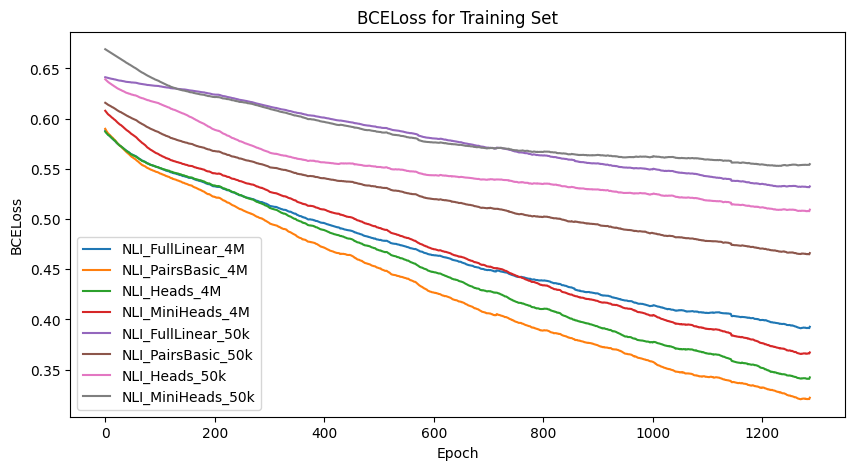

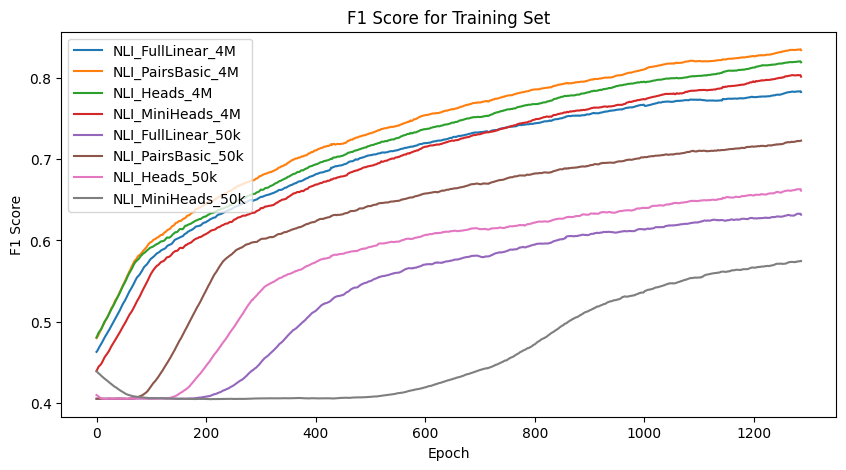

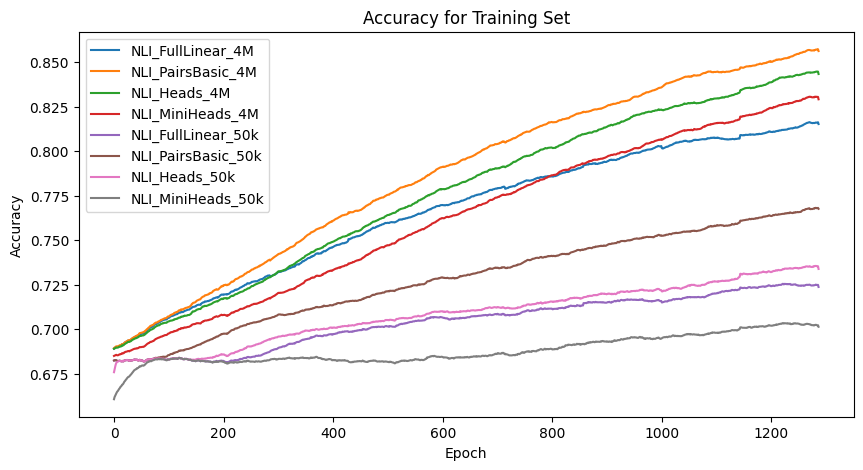

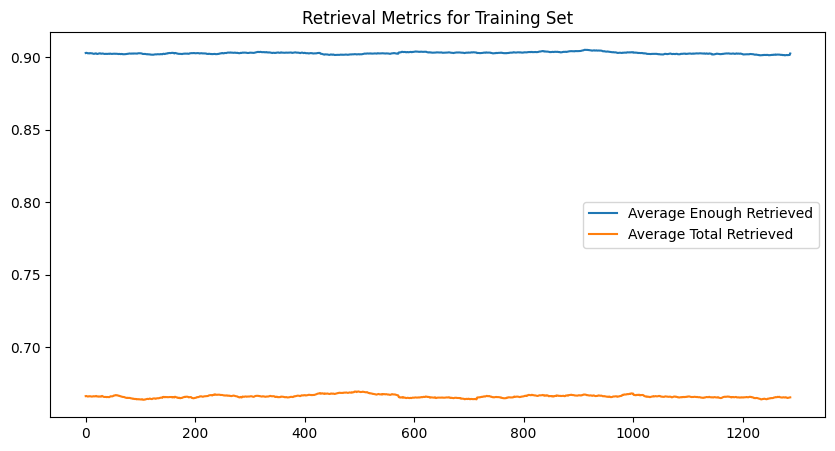

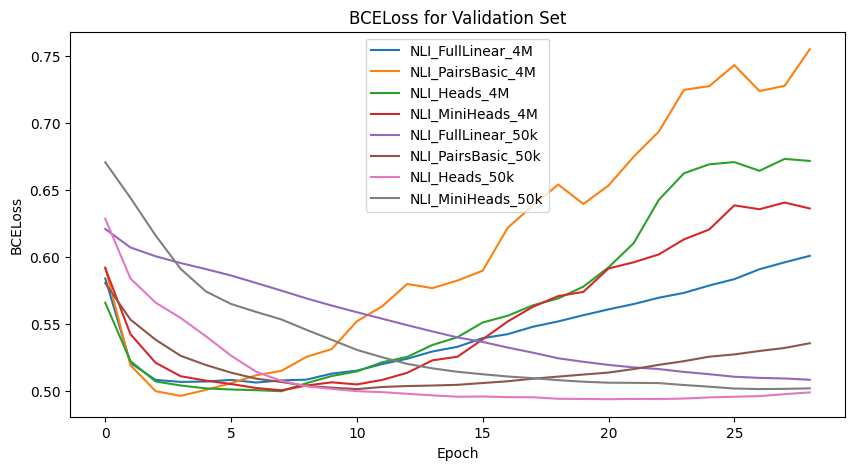

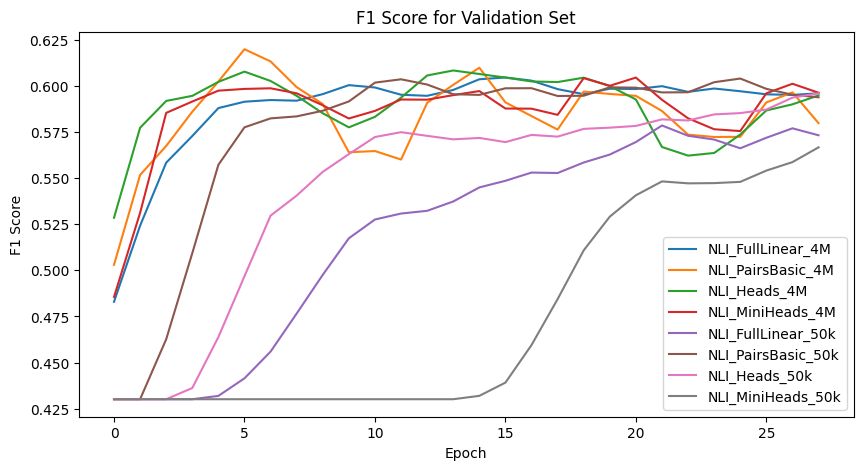

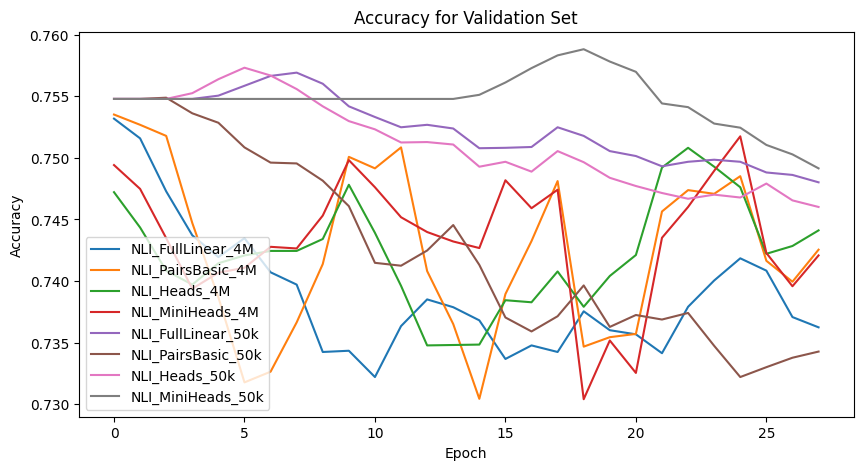

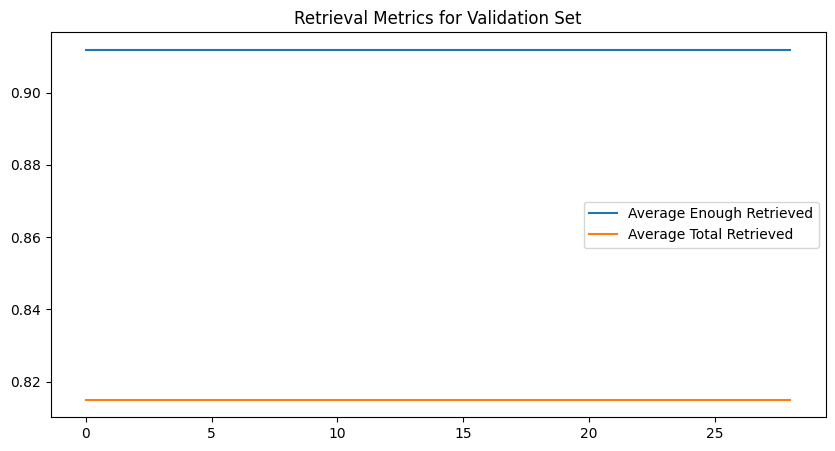

In [4]:
val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, emb_gen=emb_gen, nli=nli, val=val, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=64, ma_ratio=0.1)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)

In [5]:
import json

with open('NLI_tests/results/tracking_train_v4_v300_1.json', 'w') as f:
    json.dump(tracking_train, f)

with open('NLI_tests/results/tracking_eval_v4_v300_1.json', 'w') as f:
    json.dump(tracking_eval, f)

In [6]:
from NLI_tests.validation2 import Validation
from NLI_tests.train_eval_utils2 import get_metrics

# evaluate on the test set
tracking_test = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss2':  []}

test_fever_dataset = FeverDataset(type='test')
test_fever_loader = DataLoader(test_fever_dataset, len(test_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
test = Validation(device=device, eval_loader=test_fever_loader, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
test.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_test)
print(tracking_test)

{'nli_accuracy': [[0.7274727472747274, 0.7552755275527553, 0.7427742774277428, 0.7467746774677467, 0.7506750675067507, 0.7351735173517352, 0.7466746674667467, 0.7505750575057506]], 'nli_f1': [[0.5816015085964152, 0.546082275073935, 0.5726335122070868, 0.5611538799679506, 0.5735597541795708, 0.6010932584165387, 0.6018889515587464, 0.5861145433513855]], 'overall_accuracy': [[0.667066706670667, 0.6784678467846784, 0.677967796779678, 0.6757675767576757, 0.6796679667966796, 0.6773677367736773, 0.6832683268326832, 0.683968396839684]], 'overall_f1': [[0.5536687492133279, 0.5045668784090922, 0.5422170422170423, 0.5245532524279249, 0.5347890503287299, 0.573579804708044, 0.567938646336604, 0.5511639086055597]], 'conditional_accuracy': [[0.654065406540654, 0.6736673667366737, 0.6671667166716672, 0.6680668066806681, 0.671967196719672, 0.663066306630663, 0.6717671767176717, 0.6740674067406741]], 'conditional_f1': [[0.5278358887738765, 0.4927057930940356, 0.5187351093783842, 0.5069381952296588, 0.51